In [11]:
import wav2letter
from wav2letter.models import Wav2LetterRF

from optimal_input.opt_inp_w2l import GetOptInput

from scipy.io.wavfile import read
import yaml
import os
import numpy as np
import torch
from tqdm import tqdm

print("started")

dir = os.getcwd()
conf_file = 'config_rf.yaml'
manifest_file = os.path.join(os.path.dirname(wav2letter.__file__),"conf",conf_file)
with open(manifest_file, 'r') as f:
    model_param = yaml.load(f, Loader=yaml.FullLoader)


checkpoint_file = "Wav2letter-epoch=024-val_loss=0.37.ckpt"
checkpoint = os.path.join(model_param["results_dir"],checkpoint_file)
model = Wav2LetterRF.load_from_checkpoint(checkpoint, manifest=model_param)

for param in model.parameters():
    param.requires_grad = False
print("loaded model")

layers = ["conv" + str(x) for x in range(1, 16)]

get_opt_input = GetOptInput(model)

beta = np.load("/depot/jgmakin/data/auditory_cortex/betas/w2l_l6.npy", allow_pickle=True)

l = 6
print("starting")
for i in [32]:
    _ , aud = read("/depot/jgmakin/data/audio_data/sent_0.wav")
    aud = aud[:7500]
    get_opt_input.get_opt_input(torch.tensor(aud.astype('float32')).unsqueeze(0).T, layers[l], beta[:, i].reshape(-1, 1).astype('float32'), iterations=100)
    np.save(f'/depot/jgmakin/data/auditory_cortex/opt_inputs/w2l/loss_layer_{l}_channel_{i}.npy', get_opt_input.loss_list, allow_pickle=True)
    np.save(f'/depot/jgmakin/data/auditory_cortex/opt_inputs/w2l/layer_{l}_channel_{i}.npy', get_opt_input.aud.detach().numpy(), allow_pickle=True)

started
loaded model
starting


100%|██████████| 100/100 [52:02<00:00, 31.23s/it] 


In [27]:
import matplotlib.pyplot as plt
from transformers import Speech2TextFeatureExtractor


loss = np.load(f'/depot/jgmakin/data/auditory_cortex/opt_inputs/w2l/loss_layer_{l}_channel_{i}.npy', allow_pickle=True)
values = np.load(f'/depot/jgmakin/data/auditory_cortex/opt_inputs/w2l/layer_{l}_channel_{i}.npy', allow_pickle=True)

feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")

spect_opt = feature_extractor(values.reshape(-1,), sampling_rate=16000, return_tensors="np").input_features

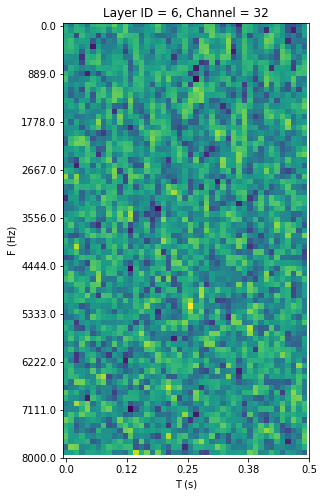

In [32]:
plt.figure(figsize=(5,8))

plt.imshow(spect_opt[0].T)
plt.xticks(np.linspace(0, 45, 5), np.round(np.linspace(0,0.5, 5), 2))
plt.yticks(np.linspace(0, 80, 10), np.round(np.linspace(0,8000, 10)))
plt.ylabel("F (Hz)")
plt.xlabel("T (s)")

plt.title("Layer ID = 6, Channel = 32")
plt.show()

In [2]:
from wav2letter.models import Wav2LetterRF
from auditory_cortex.feature_extractors import FeatureExtractorW2L

import wav2letter

import torch
import yaml
import os
from scipy.io.wavfile import read




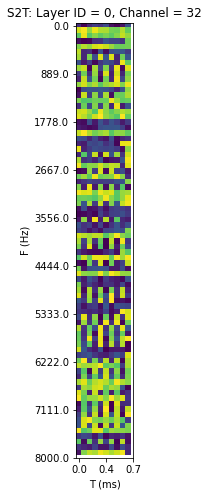

In [53]:
l0 = np.load("/depot/jgmakin/data/auditory_cortex/opt_inputs/layer_0_64_channels.npy", allow_pickle=True)
l1 = np.load("/depot/jgmakin/data/auditory_cortex/opt_inputs/layer_1_64_channels.npy", allow_pickle=True)

plt.figure(figsize=(10,8))

plt.imshow(l0[32])
plt.xticks(np.linspace(0, 10, 3), np.round(np.linspace(0,0.7, 3),1))
plt.yticks(np.linspace(0, 80, 10), np.round(np.linspace(0,8000, 10)))
plt.ylabel("F (Hz)")
plt.xlabel("T (ms)")

plt.title("S2T: Layer ID = 0, Channel = 32")
plt.show()

In [59]:
l1[32].shape

(80, 30)

In [78]:
spect_opt[0].shape

(45, 80)

In [91]:
from optimal_input.utils import corr

A = l1[32].T
B = spect_opt[0]

c = corr(A, B)

(45, 80)
(74, 80)
(74, 80)
[[   9.06613731    9.06613731    9.06613731 ...    9.06613731
     9.06613731    9.06613731]
 [  11.06484699   11.06484699   11.06484699 ...   11.06484699
    11.06484699   11.06484699]
 [ -17.18861771  -17.18861771  -17.18861771 ...  -17.18861771
   -17.18861771  -17.18861771]
 ...
 [-102.71417999 -102.71417999 -102.71417999 ... -102.71417999
  -102.71417999 -102.71417999]
 [ -55.95294952  -55.95294952  -55.95294952 ...  -55.95294952
   -55.95294952  -55.95294952]
 [  -8.67536163   -8.67536163   -8.67536163 ...   -8.67536163
    -8.67536163   -8.67536163]]


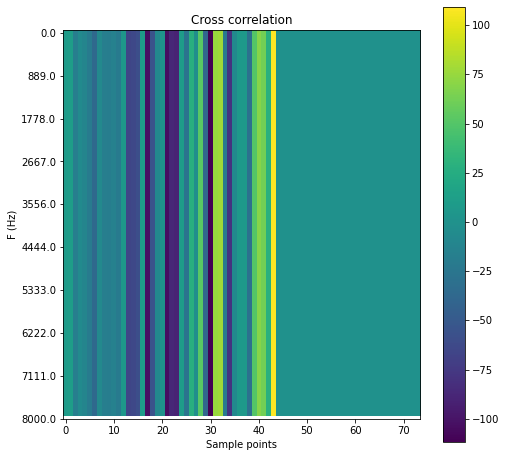

In [103]:
plt.figure(figsize=(8,8))

plt.imshow(c.T)
# plt.xticks(np.linspace(0, 74, 10), np.round(np.linspace(0,, 3),1))
plt.yticks(np.linspace(0, 80, 10), np.round(np.linspace(0,8000, 10)))
plt.ylabel("F (Hz)")
plt.xlabel("Sample points")
plt.colorbar()
plt.title("Cross correlation")
plt.show()

In [3]:
dir = os.getcwd()
conf_file = 'config_rf.yaml'
manifest_file = os.path.join(os.path.dirname(wav2letter.__file__),"conf",conf_file)
with open(manifest_file, 'r') as f:
    model_param = yaml.load(f, Loader=yaml.FullLoader)

checkpoint_file = "Wav2letter-epoch=024-val_loss=0.37.ckpt"
checkpoint = os.path.join(model_param["results_dir"],checkpoint_file)
model = Wav2LetterRF.load_from_checkpoint(checkpoint, manifest=model_param)

layers = ["conv" + str(x) for x in range(1, 16)]

In [4]:
from optimal_input.get_betas import GetBetas
data_dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
sub = '200206'
get_beta = GetBetas(data_dir=data_dir, sub=sub, model=model)

Creating dataset and other objects...
done


In [ ]:
from optimal_input.opt_inp_w2l import GetOptInput

for param in model.parameters():
    param.requires_grad = False
get_opt_input = GetOptInput(model)

In [ ]:
from tqdm import tqdm
sr, aud = read("/depot/jgmakin/data/audio_data/sent_0.wav")
aud = aud
for i in tqdm(range(2)):
    get_opt_input.get_opt_input(torch.tensor(aud.astype('float32')).unsqueeze(0).T, layers[0], beta_l0[:, i].reshape(-1, 1).astype('float32'), iterations=2)
    # loss_l0.append(get_opt_input.loss_list)
    # spect_l0.append(get_opt_input.spect[0].detach().numpy().T)
    # np.save(f'/depot/jgmakin/data/auditory_cortex/opt_inputs/layer_0_channel_{i}.npy', get_opt_input.aud.detach().numpy(), allow_pickle=True)